In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as st

# Mediterranean earthquake statistics

The data is from US Geological Survey - https://earthquake.usgs.gov/<br>
https://earthquake.usgs.gov/earthquakes/search/<br><br>
Earthquakes in Mediterranean area since 1900 through 2022, above magnitude 4.5

<b>Remark</b><br>
There is a charpter about earthquake predictions in the book 'The Signal and the Noise' by Nate Silver. The bottom line is that we still can't predict events, like in meteorology. But we do have <a href='https://en.wikipedia.org/wiki/Gutenberg%E2%80%93Richter_law'>Gutenberg–Richter law</a>:<br>
looking on low-magnitude earthquakes frequences we can get an average frequency of bigger earthquaqes.<br> We will plot this relation for our area of interest further

In [2]:
eq = pd.read_csv('mediter/query.csv', encoding='utf8')

In [3]:
eq.head()

time  latitude  longitude  depth  mag magType  nst  \
0  1905-09-08T01:43:02.000Z    38.636     15.784   15.0  7.2      mw  NaN   
1  1905-11-08T22:06:10.000Z    39.114     23.974   15.0  7.4      mw  NaN   
2  1905-12-04T07:05:30.000Z    38.153     38.645   10.0  6.8      mw  NaN   
3  1908-12-28T04:20:26.000Z    38.000     15.349   15.0  7.0      mw  NaN   
4  1909-02-09T11:23:57.000Z    39.665     38.027   15.0  6.3      mw  NaN   

   gap  dmin  rms  ...                   updated  \
0  NaN   NaN  NaN  ...  2020-07-09T21:56:20.965Z   
1  NaN   NaN  NaN  ...  2020-07-10T13:28:38.981Z   
2  NaN   NaN  NaN  ...  2020-07-10T13:34:53.841Z   
3  NaN   NaN  NaN  ...  2020-07-09T21:59:45.219Z   
4  NaN   NaN  NaN  ...  2020-07-10T13:32:27.459Z   

                             place        type horizontalError depthError  \
0      5 km W of San Nicolò, Italy  earthquake             NaN        NaN   
1  10 km ESE of Patitírion, Greece  earthquake             NaN        NaN   
2      13 km NNE of Sincik, Turkey  earthquake             NaN        NaN   
3      1 km NNW of Pagliara, Italy  earthquake             NaN        NaN   
4     24 km SSW of ?mranl?, Turkey  earthquake             NaN        NaN   

   magError  magNst     status  locationSource magSource  
0       NaN     NaN  automatic          iscgem    iscgem  
1       NaN     NaN  automatic          iscgem    iscgem  
2       NaN     NaN  automatic          iscgem    iscgem  
3       NaN     NaN  automatic          iscgem    iscgem  
4       NaN     NaN  automatic          iscgem    iscgem  

[5 rows x 22 columns]

In [4]:
len(eq)

5155

Cheking which types of events we have in set

In [5]:
eq.type.unique()

array(['earthquake'], dtype=object)

In [6]:
eq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5155 entries, 0 to 5154
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             5155 non-null   object 
 1   latitude         5155 non-null   float64
 2   longitude        5155 non-null   float64
 3   depth            5155 non-null   float64
 4   mag              5155 non-null   float64
 5   magType          5155 non-null   object 
 6   nst              1116 non-null   float64
 7   gap              1981 non-null   float64
 8   dmin             1050 non-null   float64
 9   rms              3438 non-null   float64
 10  net              5155 non-null   object 
 11  id               5155 non-null   object 
 12  updated          5155 non-null   object 
 13  place            5155 non-null   object 
 14  type             5155 non-null   object 
 15  horizontalError  1057 non-null   float64
 16  depthError       2116 non-null   float64
 17  magError      

Will use <b>time</b> column, <b>place</b> and <b>magnitude</b>, there is no lacks at those columns

converting time to date and times columns

In [7]:
eq.time.head()

0    1905-09-08T01:43:02.000Z
1    1905-11-08T22:06:10.000Z
2    1905-12-04T07:05:30.000Z
3    1908-12-28T04:20:26.000Z
4    1909-02-09T11:23:57.000Z
Name: time, dtype: object

In [8]:
eq[['date', 'times']] = eq['time'].str.split('T', expand=True)

In [9]:
eq.date.head()

0    1905-09-08
1    1905-11-08
2    1905-12-04
3    1908-12-28
4    1909-02-09
Name: date, dtype: object

## Displaying all earthquakes

Plotting all earthquakes by magnitude on time axis, checking how data is balanced

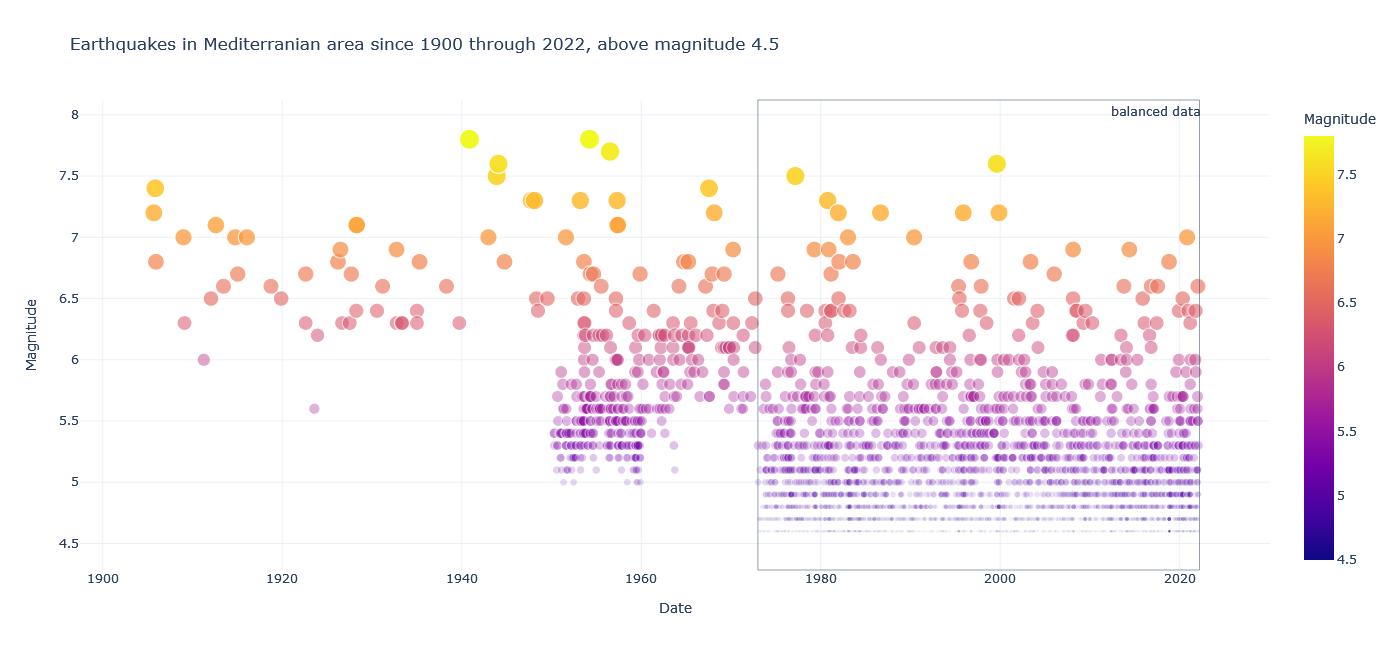

In [14]:
# plot all events
eq['size'] = (eq.mag - eq.mag.min()) / (eq.mag.max() - eq.mag.min())
opacity = eq['size'] ** .99
fig = px.scatter(eq, 
                x='date',
                y='mag',
                title='Earthquakes in Mediterranean area since 1900 through 2022, above magnitude 4.5',
                hover_name='place',
                size='size',
                opacity=opacity,
                color='mag',
                hover_data = {'mag': True,
                             'date': True,
                            'size': False,
                            'latitude': False,
                            'longitude': False},
                labels={
                    'date': 'Date',
                    'mag': 'Magnitude',
                        },                 
                width=900, height=650,
                template='plotly_white')
fig.add_vrect(x0='1973-01-01', x1=eq.date.iloc[-1],
                  annotation_text="balanced data",
              line_width=0.5
             )
fig.show()

Before 1973 data was not collected equally for all periods and there is a lack of low-magnitude events, we will use only balanced period for log plot illustrating the Gutenberg–Richter law

## Plotting maximum magnitudes by year, hypotesis cheking

Another option to check a balanced portion of data is to look only at maximum magnitudes by every year. We will plot maximums by year with all rest events grayed

In [12]:
eq['date'] = pd.to_datetime(eq.date, format='%Y-%m-%d')
eq['year'] = pd.DatetimeIndex(eq['date']).year
eq['date_str'] = eq['date'].astype('string')

In [13]:
eq_year_max = eq.groupby('year', as_index=False).max()
# eq_year_max.head()

In [14]:
# There is still a lot of assymetry in data, we have to fix it:
limit = 6.5
eq_year_max = eq_year_max[eq_year_max['mag'] > limit]

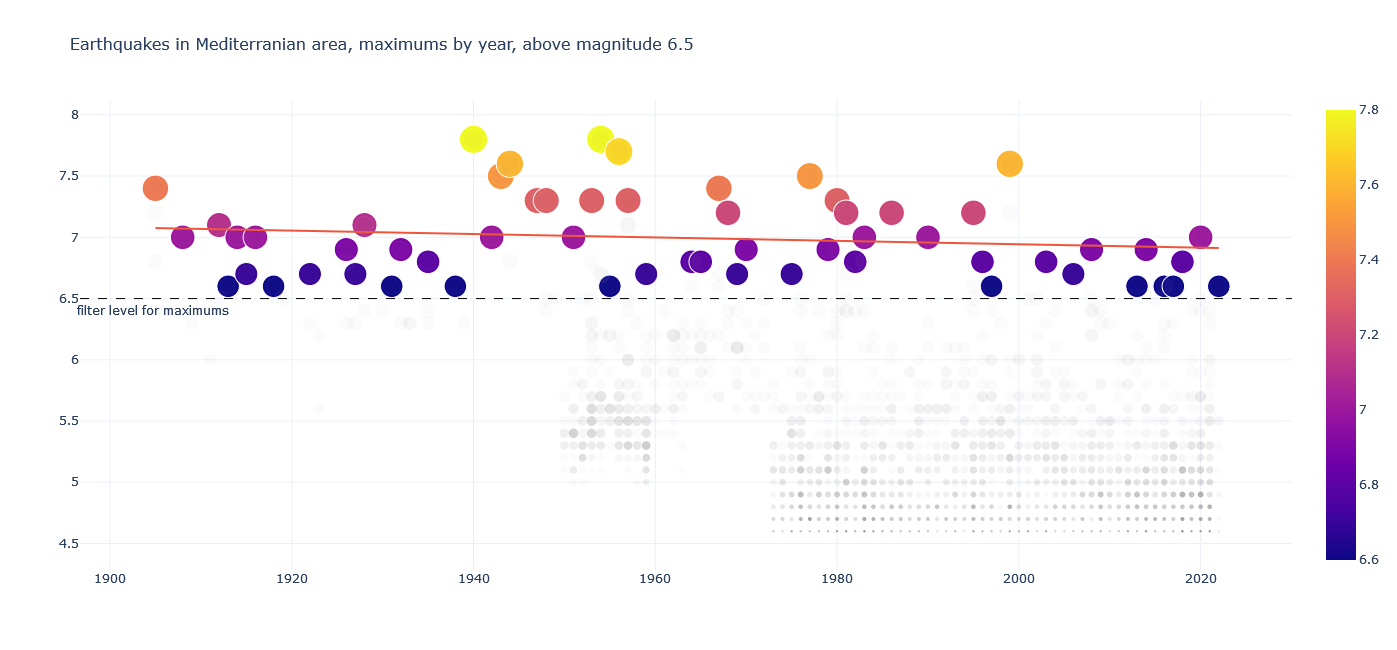

In [20]:
fig_max = px.scatter(eq_year_max, 
                x='year',
                y='mag',
                hover_name='place',
                size='size',
                opacity=1,
                color='mag',
                hover_data = {'mag': True,
                             'date_str': True,
                            'size': False,
                            'latitude': False,
                            'longitude': False},
                labels={
                    'date_str': 'Date',
                    'mag': 'Magnitude',
                        },                 
                trendline='ols',
                trendline_color_override='#ef553b'
                )

fig_all = px.scatter(eq, 
                x='year',
                y='mag',
                hover_data = {'mag': False,
                             'date_str': False,
                            'size': False,
                            'latitude': False,
                            'longitude': False},
                size='size',
                opacity=.04,
                color_discrete_sequence=['#777777'],              
                )

fig = go.Figure(data = fig_all.data + fig_max.data)

fig.update_layout(title_text='Earthquakes in Mediterranean area, maximums by year, above magnitude 6.5',
                  title_font_size=16,
                  template='plotly_white',
                  width=900,
                  height=650
                  )
fig.add_hline(y=limit, line_width=1, line_dash='dash', line_color='black', annotation_text='filter level for maximums', annotation_position='bottom left')
fig.show()


We suppose that there is no trend here, so trendline should be horizontal or near that slope (any slope here is only random 'noise')<br>

Anyway, let's check if this trend is statiscally significant:<br>
* H0: There is no trend, the trendline slope is only a result of noise
* H1: There is some trend and statistically significant shift between magnitudes of events by time<br>

On purpose to simplify the task we will divide all maximum-magnitude earthquakes into two groups:<br>
first half and second half by cronology

In [22]:
mid_date = ((eq_year_max.date.max() - eq_year_max.date.min())/2 ) + eq_year_max.date.min()
# mid_date
eq_year_max_first = eq_year_max[eq_year_max.date <= mid_date]
eq_year_max_second = eq_year_max[eq_year_max.date > mid_date]
eq_year_max_first_list = eq_year_max_first.mag
eq_year_max_second_list = eq_year_max_second.mag
print('First half have', len(eq_year_max_first), 'events')
print('Second half also have',len(eq_year_max_first))

First half have 29 events
Second half also have 29


Cheking a distribution, which we expect isn't normal even on maximums:

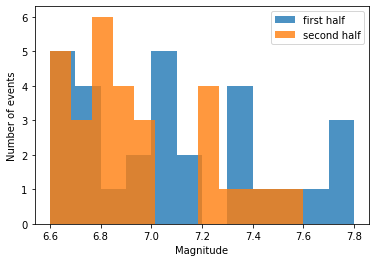

In [23]:
for df in [eq_year_max_first, eq_year_max_second]:
    plt.hist(df.mag, bins=12, alpha=.8)
    plt.legend(['first half', 'second half'])
    plt.xlabel('Magnitude')
    plt.ylabel('Number of events')
plt.show()

Now we have two lists of magnitudes, number of elements is less than 30 and distribution isn't normal, so we'll use Mann-Whitney U test to check the differences between two lists

In [25]:
p_val = st.mannwhitneyu(eq_year_max_first_list, eq_year_max_second_list, alternative='two-sided')[1]
if p_val < 0.05: 
    print('H1 is right, there is a trend')
else:
    print('H0 is right, there is no statistically significant trend')

H0 is right, there is no statistically significant trend


## Illustration of Gutenberg–Richter law

We will illustrate the Gutenberg–Richter law on data of our area of interest, from year 1973 to keep it balanced

In [26]:
eq_balanced = eq[eq.date > '1973-01-01']

In [27]:
# number of earthqukes for every magnitude for all years since 1973 through 2022
# we will divide it by 48 (number of years from 1973 to 2022)
magnitude_by_years = eq_balanced.groupby('mag', as_index=False).date.count()
# magnitude_by_years = eq.groupby('mag', as_index=False).date.count()
magnitude_by_years.date = magnitude_by_years.date/48

In [28]:
magnitude_by_years = pd.DataFrame(magnitude_by_years)
magnitude_by_years.rename(columns={'mag':'Magnitude', 'date':'Times per year'}, inplace=True)
# magnitude_by_years

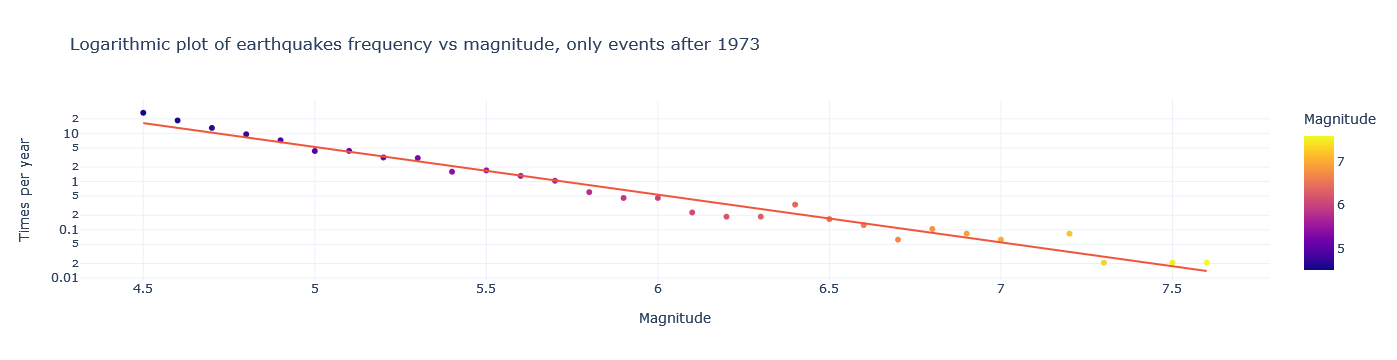

In [29]:
# plot log scale
px.scatter(magnitude_by_years,
           x='Magnitude',
           y='Times per year',
           log_y=True,
           template='plotly_white',
           title='Logarithmic plot of earthquakes frequency vs magnitude, only events after 1973',
           trendline='ols',
           trendline_options=dict(log_y=True),
           color='Magnitude'
          )


While plotting this data we also get consctants from trendline which are different by region: <br>
a = 5.67<br>
b = 0.98
<br>
<br>
The closeness of <b>b</b> to 1.0 means that area of interest is seismically active region.

## Plotting locations of earthquakes

In [31]:
limit = 5.5
limited_eq = eq[eq['mag'] > limit]

In [32]:
# plt.hist(eq.mag, bins=50)
# plt.show

In [33]:
limited_eq['size'] = (limited_eq.mag - limited_eq.mag.min()) / (limited_eq.mag.max() - limited_eq.mag.min())
opacity = limited_eq['size'] ** .4

<ipython-input-33-cd604ba03630>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



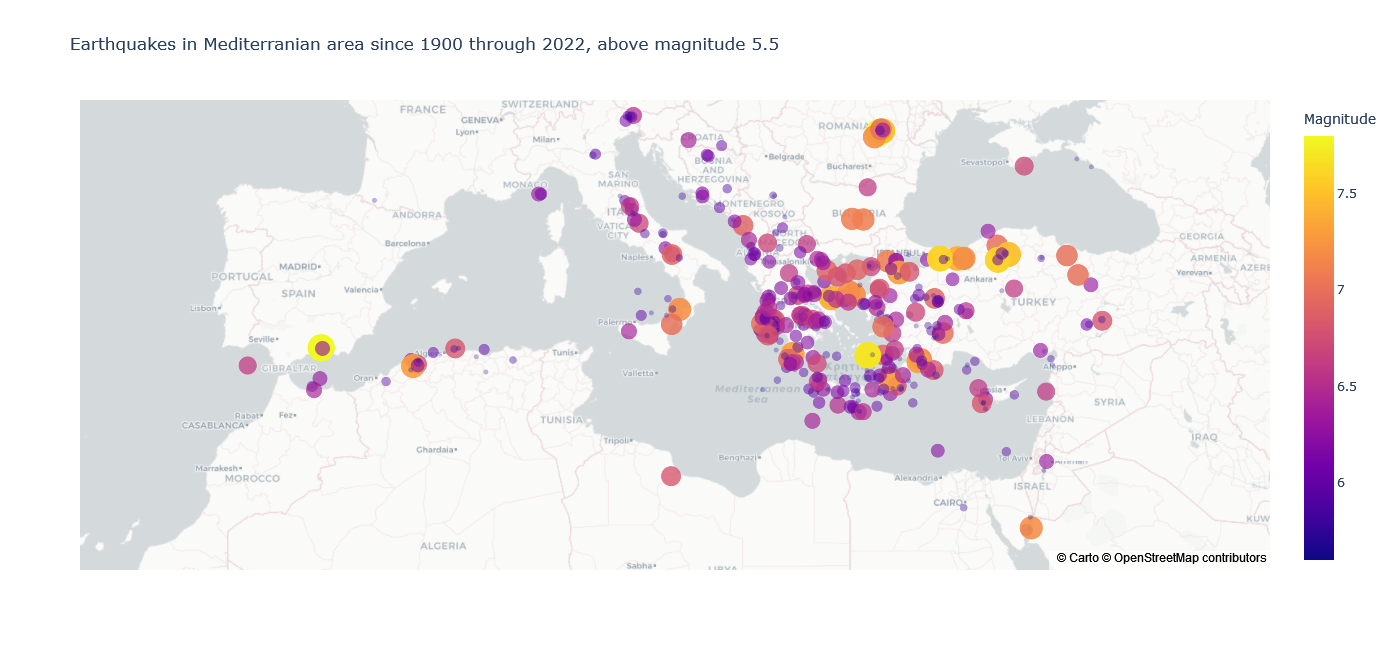

In [34]:
# plot map
title_constr = 'Earthquakes in Mediterranean area since 1900 through 2022, above magnitude ' + str(limit)
fig = px.scatter_mapbox(limited_eq, 
                        lat=limited_eq.latitude, 
                        lon=limited_eq.longitude, 
                        color='mag', 
                        size='size',
                        opacity=opacity,
                        title=title_constr,
                        hover_name='place',
                        hover_data = {'mag': True,
                                      'date_str': True,
                                      'size': False,
                                      'latitude': False,
                                      'longitude': False},
                        labels={
                         'date_str': 'Date',
                         'mag': 'Magnitude',
                        },
                        width=900, height=650,
                        zoom=3.7,
                        center={
                            'lat': limited_eq.latitude.min() + (limited_eq.latitude.max() - limited_eq.latitude.min())/2,
                            'lon': limited_eq.longitude.min() + (limited_eq.longitude.max() - limited_eq.longitude.min())/2
                        })

fig.update_layout(mapbox_style="carto-positron")

fig.show()